In [10]:
import os

# modin pandas drastically speeds up existing pandas functions so using it rather than basic pandas
# also provides the potential to use snowpark pandas api in the future/as needed
# examples of performance difference given on modin github
import modin.pandas as pd

# some generic imports from the snowpark api
from snowflake.snowpark.functions import *
import snowflake.snowpark.file_operation
import snowflake.snowpark.modin.plugin
from snowflake.snowpark import Session

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

In [11]:
# Setting Snowflake connection parameters based on the conda configuration in the conda_env.yml file
sf_connection_params = {
    "account": os.environ.get('SF_ACCOUNT'),
    "password": os.environ.get('SF_PASSWORD'),
    "user": os.environ.get('SF_USER'),
    "role": os.environ.get('SF_ROLE'),
    "warehouse": os.environ.get('SF_WAREHOUSE'),
    "database": os.environ.get('SF_DATABASE'),
    "schema": os.environ.get('SF_SCHEMA')
}

# create our snowpark session based on the above connection params
session = Session.builder.configs(sf_connection_params).create()

In [12]:
# define our function to ingest both datasets (train & test)
# the necessary snowflake file format and internal stage have been created
def nyc_taxi_ingest(session: snowflake.snowpark.Session):
    session.file.put("datasets/*", "@stg_nyc_taxi", overwrite=True) # snowpark api call to put a file (train.csv) into an internal stage (@stg_nyc_taxi)
    
    df_train = pd.read_csv('@stg_nyc_taxi/train.csv')
    df_train.to_snowflake("train", if_exists='replace', index=False, table_type='')  # write the pandas dataframe to a table named train
        
    df_test = pd.read_csv('@stg_nyc_taxi/test.csv') # read the csv into a pandas dataframe
    df_test.to_snowflake("test", if_exists='replace', index=False, table_type='') # write the pandas dataframe to a table named test

In [13]:
# For both graphs I took data from the train dataset. This comparison also uses a subset of that dataset in a new table called vendor_comparison

# For this graph I made a separate table to house only the vendor_id and the summation of the # of passengers for each vendor_id
# While a simple example, I think a question could be asked of why was there such a discrepancy between the two vendors?
# Could it be that vendor 2 had larger vehicles in it's fleet and therefore could accommodate larger parties? Or in conjunction with that
# could people have chosen that service if they had a large group for a party, at a club, etc?

# It's also interesting that while vendor 2 had more passengers per pickup, vendor 1 did a significantly larger portion of pickups in a given timeframe.
# Again, more in-depth analysis could be done as to why. 

def vendor_comparison(session: snowflake.snowpark.Session):
    vendor_df = pd.read_snowflake('vendor_comparison', index_col=False) # read the table data from Snowflake back into a snowpark pandas dataframe
    
    vendor_pd = vendor_df.to_pandas() # Snowpark pandas is still new so to make sure I had full functionality I took the snowpark pandas dataframe back into a pandas dataframe
    
    fig, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(aspect='equal'))
    
    colors = sns.color_palette('Set2') # set the colors to be easier to distinguish using the seaborn library
    
    ax.pie(vendor_pd['PASSENGER_COUNT'], colors=colors, autopct='%1.1f%%') # creating the pie graph to represent the percentage of passengers each vendor had taken out to 1 decimal place
    ax.set_title("Total % of Passengers per Vendor") # Set the title
    ax.legend(vendor_pd['VENDOR_ID'], title='vendor', loc='right', bbox_to_anchor=(1, 0, 0.5, 1)) # Set the legend
    plt.show() # Display the graph

In [14]:
# I chose to go with a histogram w/ a kde to get a better look at how many stops were being made per vendor in a given month to pickup a customer
# A deeper look into the chart shows that in general, things are fairly stable across the board in terms of how many pickups each vendor makes in a given month
# There is a drop heading into February that could be explored further; was there a snow/ice storm and people simply weren't getting out as much?
# The graph also shows the discrepancy between the number of stops made for vendor 1 vs 2. Could this be due to location of the base office for the taxis? Maybe the area vendor 1 serviced had more congestion so less people drove their own cars?
# Maybe vendor 2 had to contend more with people who rode the subway?

# Just a glimpse at some of the questions I feel could be explored further from a simple example

def pickup_distribution(session: snowflake.snowpark.Session):
    pickup_df = pd.read_snowflake('train', index_col=False) # read the table data from Snowflake back into a snowpark pandas dataframe
    
    pickup_pd = pickup_df.to_pandas() # Snowpark pandas is still new so to make sure I had full functionality I took the snowpark pandas dataframe back into a pandas dataframe
    
    custom_params = {"axes.spines.right": False, "axes.spines.top": False} # set some custom parameters for the theme of the graph; removing the right and top lines
    sns.set_theme(style='ticks', rc=custom_params) # set the theme for the graph to be tick style and include the custom parameters set above
    
    traffic = sns.histplot(data=pickup_pd, x='pickup_datetime', hue='vendor_id', multiple='stack', kde=True, palette='Set2') # create the historgram to show pickup time vs total number of pickups; stack the bars; differentiate hue by vendor_id; add a kde to better idenfify a trend; set the color palette
    traffic.set_title('Distribution of Pickup Times By Total # of Pickups', fontdict={'size': 17, 'weight': 'bold'}) # set the title of the histogram; increase the font size and weight
    traffic.set_xlabel('Pickup Time (Month)', fontdict={'size': 15}) # set the xlabel for better readability and increase font size
    traffic.set_ylabel('Total # of Pickups', fontdict={'size': 15}) # set the ylabel for better readability and clarity and increase font size

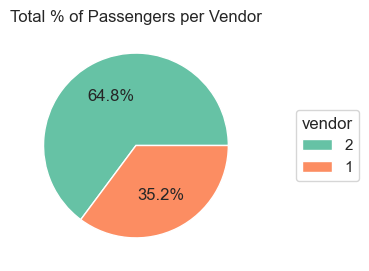

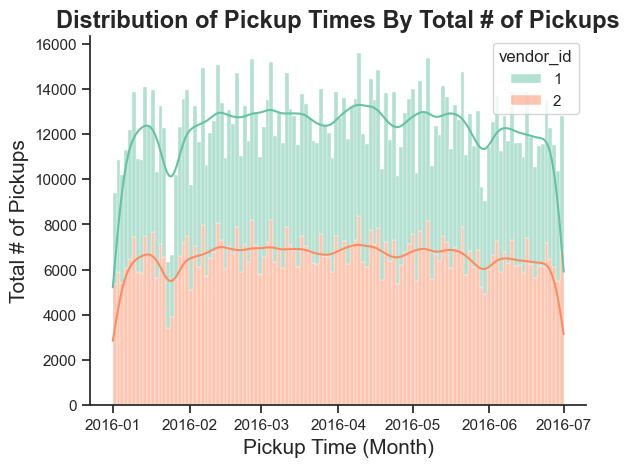

In [15]:
def main():
    #nyc_taxi_ingest(session) # Leaving this commented and to be uncommented at user discretion as it will run the full push to stage and re-creation of the tables in Snowflake using Snowpark
    vendor_comparison(session) # Call to run the vendor comparison function
    pickup_distribution(session) # Call to run the pickup distribution function
    
if __name__ == "__main__":
    main()